<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/WideDeepNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide & Deep Networks

![](https://w5coaching.com/wp-content/uploads/2017/05/Mile-wide-and-an-inch-deep.jpg)

http://arxiv.org/abs/1606.07792

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import DenseFeatures
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.data import Dataset
import tensorflow.feature_column as fc

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Random

In [2]:
np.random.seed(2001)
tf.random.set_seed(2001)

# Data

In [3]:
!wget -O adult.data https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2020-09-30 23:54:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  3.65MB/s    in 1.0s    

2020-09-30 23:54:37 (3.65 MB/s) - ‘adult.data’ saved [3974305/3974305]



## Columns
* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


In [4]:
columns = [
  'age',
  'workclass',
  'fnlwgt',
  'education',
  'education_num',
  'marital_status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'capital_gain',
  'capital_loss',
  'hours_per_week',
  'native_country',
  'target'
]

In [5]:
df = pd.read_csv('adult.data', names=columns)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# EDA

## Missing

In [6]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
target            0
dtype: int64

## Age

In [7]:
df.age.describe()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

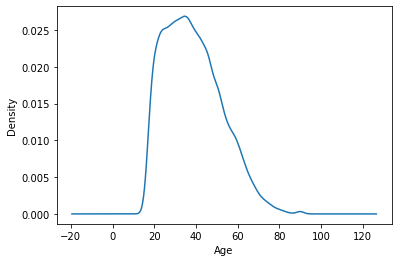

In [8]:
df.age.plot.density()
plt.xlabel('Age');

## Education
* Good feature for embedding

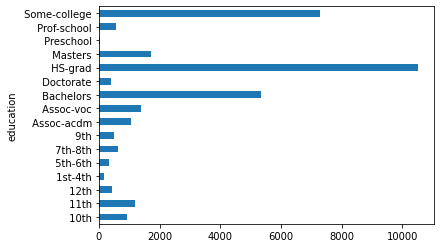

In [9]:
df.groupby('education').size().plot.barh()

## Working Class

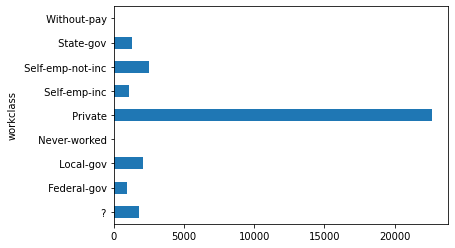

In [10]:
df.groupby('workclass').size().plot.barh()

## Race

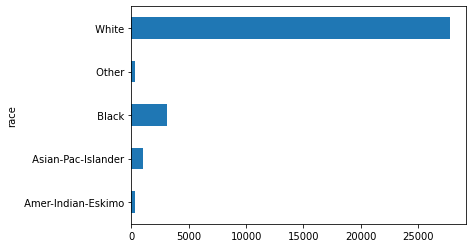

In [11]:
df.groupby('race').size().plot.barh()

## Marital Status

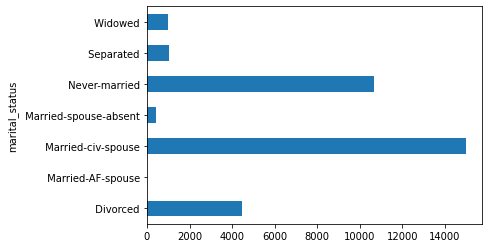

In [12]:
df.groupby('marital_status').size().plot.barh()

## Relationship

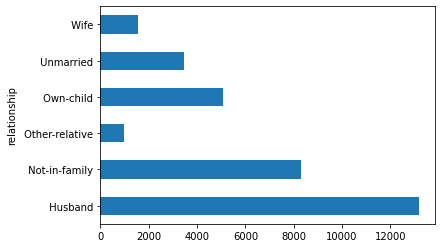

In [13]:
df.groupby('relationship').size().plot.barh()

## Sex

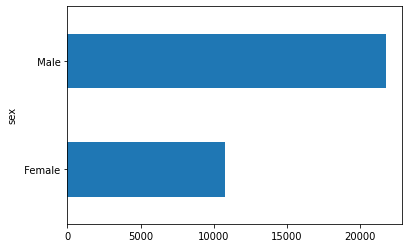

In [14]:
df.groupby('sex').size().plot.barh()

## Native Country
* Heavily Skewed to US

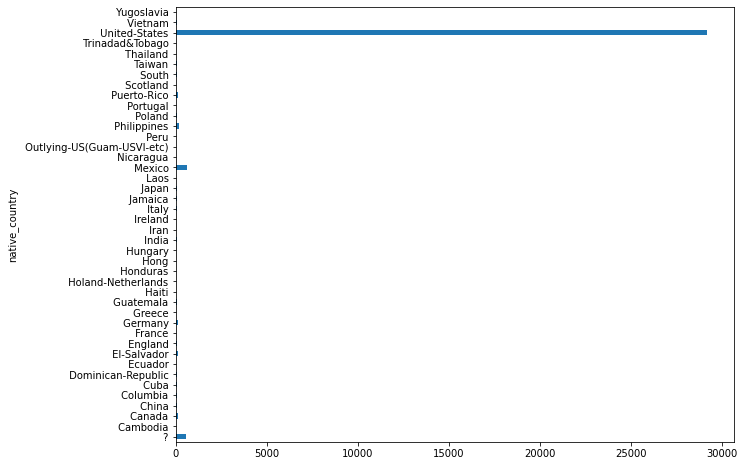

In [15]:
plt.figure(figsize=(10,8))
df.groupby('native_country').size().plot.barh()

## Capital Gains & Losses
* Possible place to engineer features
* Net Gain = Gains - Losses
* Has Gain (Present / Not)
* We should get every gain > 50K correct as well

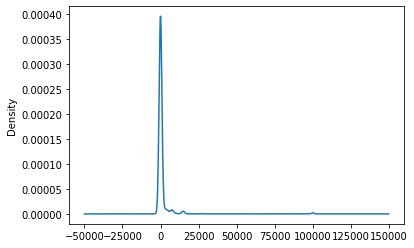

In [63]:
df.capital_gain.plot.density()

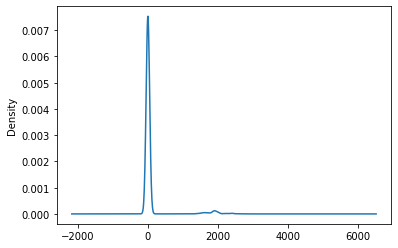

In [64]:
df.capital_loss.plot.density()

## Target
* Class balance is an issue
* For this notebook we ignore it, but we may see <= 50K perform better than >50K

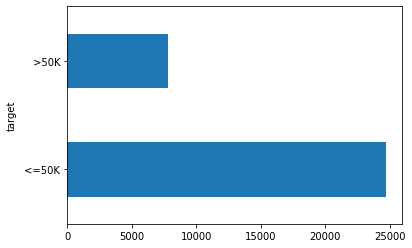

In [16]:
df.groupby('target').size().plot.barh()

In [17]:
df['y'] = np.where(df.target == ' >50K', 1, 0)

# Train Test

In [18]:
df[df.target == ' >50K']

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target,y
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K,1
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K,1
32545,39,Local-gov,111499,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,>50K,1
32554,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K,1
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1


In [19]:
df_train, df_test = train_test_split(df)
df_train, df_val  = train_test_split(df_train, test_size=0.1)

# Feature Columns

![](https://miro.medium.com/max/700/1*fYLBsPF_BZ0RuL0vt0CzXw.jpeg)

## Feature Engineering

### Binning
Feature Columns can automatically apply binning

```python
age        = fc.numeric_column('age')
binned_age = fc.bucketized_column(age, boundaries=[18, 30, 50, 65, 99])
```

### Crossing
Add interactions by crossing categorical features

```python
departure_id = fc.categorical_column('dep_airport')
arrival_id   = fc.categorical_column('arr_airport')
route = crossed_column(['dep_airport', 'arr_airport'], 50K)
```

### Shared Embedding
Embeddings can be shared across multiple columns.  

```python
embed_size =
departure_id = fc.categorical_column('dep_airport')
arrival_id   = fc.categorical_column('arr_airport')
airports     = fc.shared_embedding_columns([departure_id, arrival_id], dimension=10)
```

## Define

Define the columns as numeric or categorical

In [20]:
numeric_cols = ['age', 
                'capital_gain', 
                'capital_loss', 
                'hours_per_week']
                
sparse_cols  = ['workclass', 
                'education', 
                'marital_status', 
                'relationship', 
                'race', 
                'sex', 
                'occupation',
                'native_country']

Assign columns to numeric valued or sparse encoding

In [22]:
real = {
    colname : fc.numeric_column(colname) 
          for colname in numeric_cols
}

sparse = {
      'workclass'      : fc.categorical_column_with_hash_bucket('workclass',      hash_bucket_size=1000),
      'education'      : fc.categorical_column_with_hash_bucket('education',      hash_bucket_size=1000),
      'marital_status' : fc.categorical_column_with_hash_bucket('marital_status', hash_bucket_size=1000),
      'relationship'   : fc.categorical_column_with_hash_bucket('relationship',   hash_bucket_size=1000),
      'race'           : fc.categorical_column_with_hash_bucket('race',           hash_bucket_size=1000),
      'sex'            : fc.categorical_column_with_hash_bucket('sex',            hash_bucket_size=1000),
      'occupation'     : fc.categorical_column_with_hash_bucket('occupation',     hash_bucket_size=1000),
      'native_country' : fc.categorical_column_with_hash_bucket('native_country', hash_bucket_size=1000)
}

Create an Input layer for each col in numerica and sparse

In [23]:
inputs = {
    colname : Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}

inputs.update({
    colname : Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

Wrap sparse with an indicator cols and add embeddings to our numerics

In [24]:
embed = {
       'embed_{}'.format(colname) : fc.embedding_column(col, 10) 
          for colname, col in sparse.items()
}
real.update(embed)


sparse = {
    colname : fc.indicator_column(col) 
          for colname, col in sparse.items()
}

## Objects

In [25]:
real

{'age': NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'capital_gain': NumericColumn(key='capital_gain', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'capital_loss': NumericColumn(key='capital_loss', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'embed_education': EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='education', hash_bucket_size=1000, dtype=tf.string), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f2a488f1278>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 'embed_marital_status': EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='marital_status', hash_bucket_size=1000, dtype=tf.string), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f2a488f1128>, ckpt_to_load_from=

In [26]:
sparse

{'education': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='education', hash_bucket_size=1000, dtype=tf.string)),
 'marital_status': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='marital_status', hash_bucket_size=1000, dtype=tf.string)),
 'native_country': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='native_country', hash_bucket_size=1000, dtype=tf.string)),
 'occupation': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='occupation', hash_bucket_size=1000, dtype=tf.string)),
 'race': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='race', hash_bucket_size=1000, dtype=tf.string)),
 'relationship': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='relationship', hash_bucket_size=1000, dtype=tf.string)),
 'sex': IndicatorColumn(categorical_column=HashedCategoricalColumn(key='sex', hash_bucket_size=1000, dtype=tf.string)),
 'workclass': IndicatorColumn(categorical_column=HashedCategoricalColu

In [27]:
inputs

{'age': <tf.Tensor 'age:0' shape=(None,) dtype=float32>,
 'capital_gain': <tf.Tensor 'capital_gain:0' shape=(None,) dtype=float32>,
 'capital_loss': <tf.Tensor 'capital_loss:0' shape=(None,) dtype=float32>,
 'education': <tf.Tensor 'education:0' shape=(None,) dtype=string>,
 'hours_per_week': <tf.Tensor 'hours_per_week:0' shape=(None,) dtype=float32>,
 'marital_status': <tf.Tensor 'marital_status:0' shape=(None,) dtype=string>,
 'native_country': <tf.Tensor 'native_country:0' shape=(None,) dtype=string>,
 'occupation': <tf.Tensor 'occupation:0' shape=(None,) dtype=string>,
 'race': <tf.Tensor 'race:0' shape=(None,) dtype=string>,
 'relationship': <tf.Tensor 'relationship:0' shape=(None,) dtype=string>,
 'sex': <tf.Tensor 'sex:0' shape=(None,) dtype=string>,
 'workclass': <tf.Tensor 'workclass:0' shape=(None,) dtype=string>}

# Dataset

In [28]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target            object
y                  int64
dtype: object

In [29]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0


In [30]:
def to_dataset(df, shuffle=True, batch_size=32):
  dataframe = df.copy()
  labels = dataframe.pop('y')
  
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  
  return ds

In [31]:
cols = ['y'] + numeric_cols + sparse_cols
dataset_train = to_dataset(df_train[cols])
dataset_val   = to_dataset(df_val[cols],  shuffle=False)
dataset_test  = to_dataset(df_test[cols], shuffle=False)

# Parameters

In [32]:
BATCH_SIZE=128
EPOCHS=50

# Deep Model
* We want our deep model to generalize
* Using embeddings, we look for it to find similarity

![](https://3.bp.blogspot.com/-O6Ssu0m0_O8/V3MhQWN10AI/AAAAAAAABHE/V1PtDHKp2MQQ9jfuyHxs2HHR7Ovg5M6LQCLcB/s1600/image01.png)

## Model

In [33]:
deep = DenseFeatures(real.values())(inputs)
deep = Dense(64, activation='relu')(deep)
deep = Dense(16, activation='relu')(deep)
output = Dense(1, activation='sigmoid')(deep)
model = Model(inputs, output)

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
capital_loss (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None,)]            0                                            
_______________________________________________________________________________________

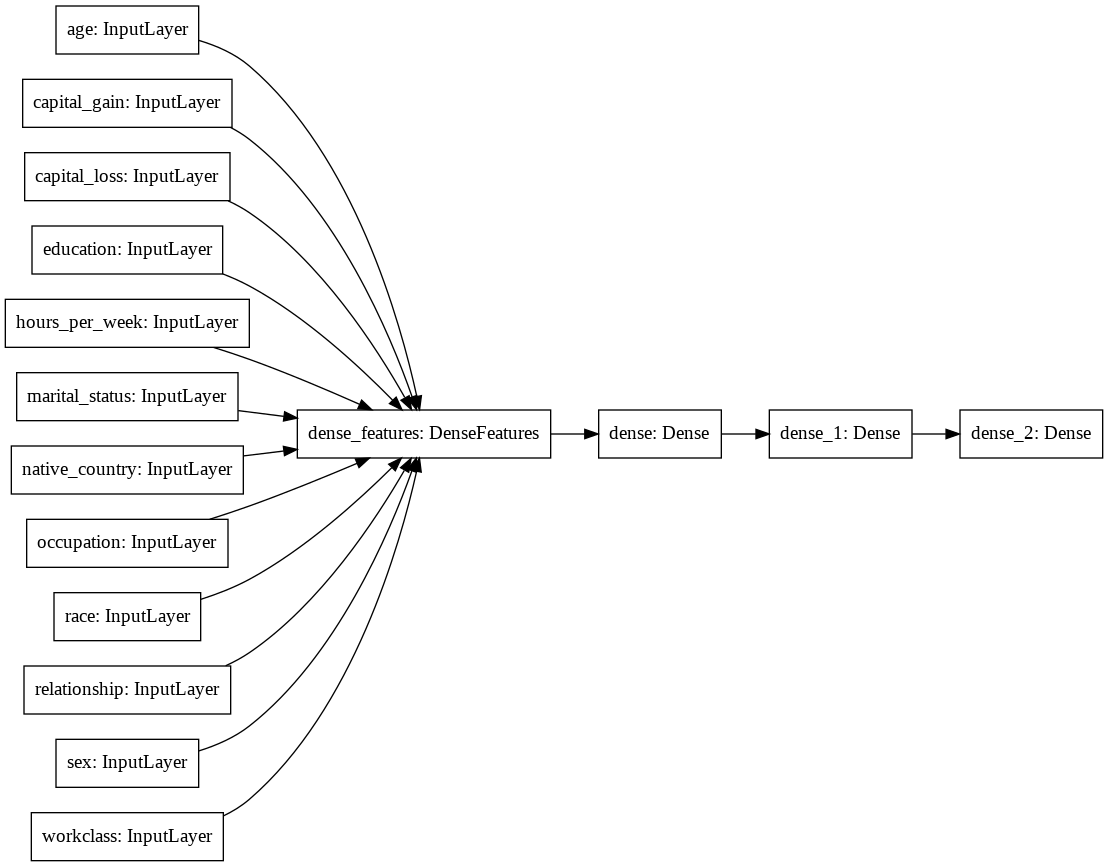

In [35]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

## Train

In [36]:
stop = EarlyStopping(patience=3)
history = model.fit(dataset_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_data=dataset_val, callbacks=[stop])

Epoch 1/50
687/687 [==============================] - 3s 4ms/step - loss: 1.8366 - accuracy: 0.8082 - val_loss: 0.5536 - val_accuracy: 0.8509
Epoch 2/50
687/687 [==============================] - 2s 3ms/step - loss: 0.5829 - accuracy: 0.8370 - val_loss: 0.5565 - val_accuracy: 0.8456
Epoch 3/50
687/687 [==============================] - 2s 3ms/step - loss: 0.8697 - accuracy: 0.8383 - val_loss: 1.3848 - val_accuracy: 0.8497
Epoch 4/50
687/687 [==============================] - 2s 3ms/step - loss: 1.0644 - accuracy: 0.8392 - val_loss: 0.5109 - val_accuracy: 0.8587
Epoch 5/50
687/687 [==============================] - 2s 3ms/step - loss: 0.6475 - accuracy: 0.8446 - val_loss: 0.6269 - val_accuracy: 0.8604
Epoch 6/50
687/687 [==============================] - 2s 3ms/step - loss: 0.8186 - accuracy: 0.8463 - val_loss: 0.6360 - val_accuracy: 0.8403
Epoch 7/50
687/687 [==============================] - 2s 3ms/step - loss: 0.9278 - accuracy: 0.8453 - val_loss: 0.7654 - val_accuracy: 0.8395


## Test

In [37]:
results = model.evaluate(dataset_test)
print("test loss, test acc:", results)

255/255 [==============================] - 0s 2ms/step - loss: 0.7905 - accuracy: 0.8274
test loss, test acc: [0.7904967069625854, 0.8274167776107788]


In [38]:
pred = model.predict(dataset_test)
pred_class = np.where(pred.squeeze() > 0.5, 1, 0)
accuracy = accuracy_score(pred_class, df_test.y)
print(f'Test Accuracy {accuracy * 100.:.2f}%')

Test Accuracy 82.74%


In [39]:
print(classification_report(pred_class, df_test.y))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      7088
           1       0.41      0.78      0.54      1053

    accuracy                           0.83      8141
   macro avg       0.69      0.81      0.72      8141
weighted avg       0.89      0.83      0.85      8141



# Wide & Deep Model

![](https://2.bp.blogspot.com/-wkrmRibw_GM/V3Mg3O3Q0-I/AAAAAAAABG0/Jm3Nl4-VcYIJ44dA5nSz6vpTyCKF2KWQgCKgB/s1600/image03.png)

## Model

In [40]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = DenseFeatures(dnn_feature_columns, name='Deep')(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    
    wide = DenseFeatures(linear_feature_columns, name='Wide')(inputs)

    both = Concatenate()([deep, wide])
    output = Dense(1, activation='sigmoid')(both)
    
    model = Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [41]:
model = wide_and_deep_classifier(inputs, sparse.values(), real.values(), [64, 16])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
capital_loss (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None,)]            0                                            
_______________________________________________________________________________________

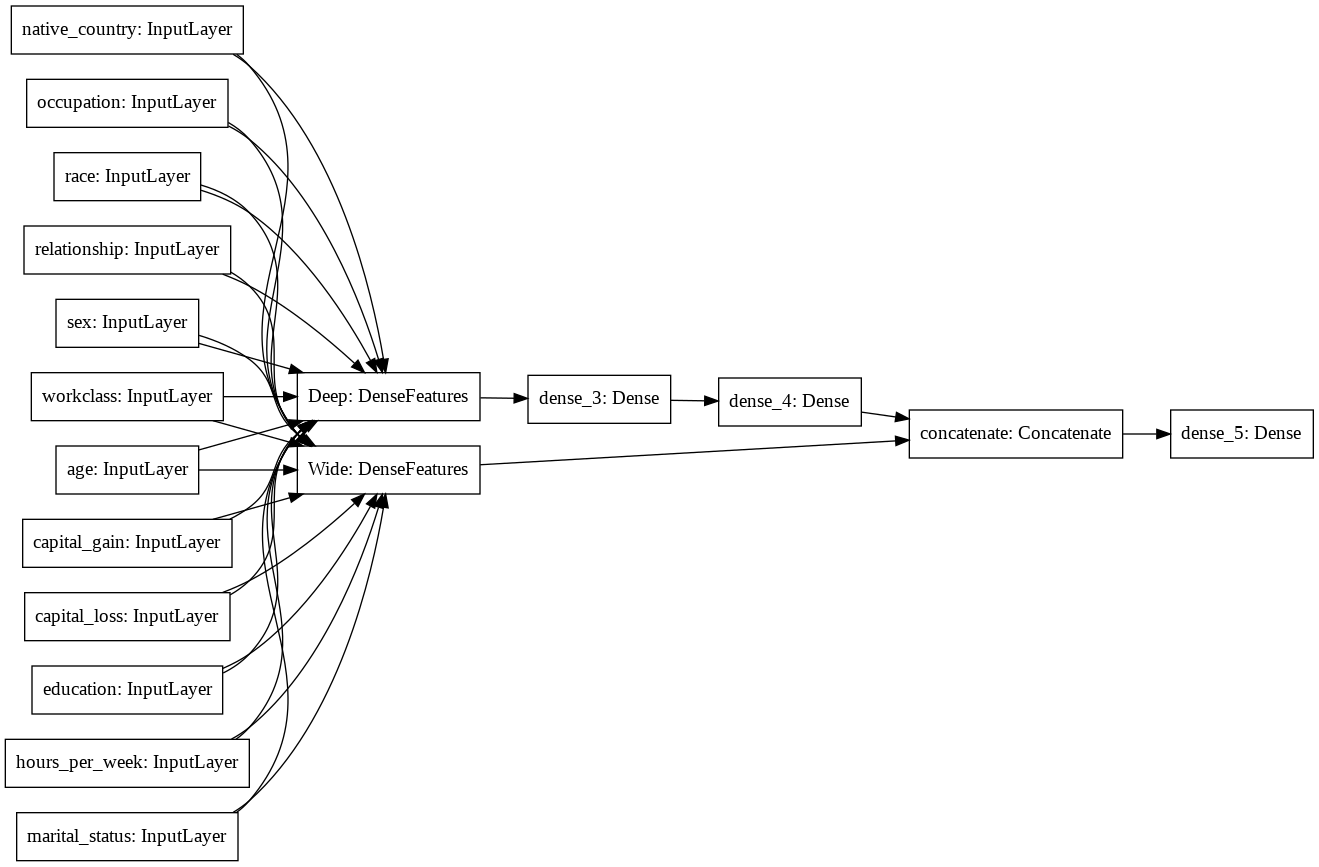

In [42]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

## Deep
* In Wide and Deep models we want the architecture to find relatedness / generalization
* For deep use embeddings for categorical features in addition to numeric features

In [43]:
for feature in real.values():
  print(feature)

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='capital_gain', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='capital_loss', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='hours_per_week', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='workclass', hash_bucket_size=1000, dtype=tf.string), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f2a488e9ef0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='education', hash_bucket_size=1000, dtype=tf.string), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f2a488f1278>, ckpt_to_

## Wide
* For wide, we use indicator and interaction factors in a shallow network
* Wide factors are akin to memorization where we hope to find places where the architecture is highly correlated with the outcome
* Wide leads to easily interpretable features

In [44]:
for feature in sparse.values():
  print(feature)

IndicatorColumn(categorical_column=HashedCategoricalColumn(key='workclass', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='education', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='marital_status', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='relationship', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='race', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='sex', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='occupation', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='native_country', hash_bucket_size=1000, dtype=tf.string))


 ## Train

In [45]:
stop = EarlyStopping(patience=3)
history_wd = model.fit(dataset_train, validation_data=dataset_val,
                       epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[stop])

Epoch 1/50
687/687 [==============================] - 5s 7ms/step - loss: 0.4123 - accuracy: 0.8186 - val_loss: 0.3433 - val_accuracy: 0.8481
Epoch 2/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3385 - accuracy: 0.8429 - val_loss: 0.3359 - val_accuracy: 0.8489
Epoch 3/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3268 - accuracy: 0.8488 - val_loss: 0.3179 - val_accuracy: 0.8563
Epoch 4/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3211 - accuracy: 0.8525 - val_loss: 0.3121 - val_accuracy: 0.8649
Epoch 5/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3188 - accuracy: 0.8531 - val_loss: 0.3169 - val_accuracy: 0.8554
Epoch 6/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3157 - accuracy: 0.8522 - val_loss: 0.3095 - val_accuracy: 0.8559
Epoch 7/50
687/687 [==============================] - 4s 5ms/step - loss: 0.3146 - accuracy: 0.8547 - val_loss: 0.3102 - val_accuracy: 0.8624
Epoch 

## Test

In [46]:
results_wd = model.evaluate(dataset_test)
print("test loss, test acc:", results_wd)

255/255 [==============================] - 1s 3ms/step - loss: 0.3178 - accuracy: 0.8546
test loss, test acc: [0.3177884519100189, 0.854563295841217]


In [47]:
pred = model.predict(dataset_test)
pred_class = np.where(pred.squeeze() > 0.5, 1, 0)
accuracy = accuracy_score(pred_class, df_test.y)
print(f'Test Accuracy {accuracy * 100.:.2f}%')

Test Accuracy 85.46%


In [48]:
print(classification_report(pred_class, df_test.y))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      6375
           1       0.65      0.73      0.68      1766

    accuracy                           0.85      8141
   macro avg       0.78      0.81      0.79      8141
weighted avg       0.86      0.85      0.86      8141



# Wider and Deeper Model
We take advantage of feature engineering options to build new interactions

## Model

In [49]:
wider = sparse.copy()

crosses = {
    'education_x_native_country'      : fc.indicator_column(fc.crossed_column(['education', 'native_country'], 1000)),
    'workclass_x_native_country'      : fc.indicator_column(fc.crossed_column(['workclass', 'native_country'], 1000)),
    'marital_status_x_native_country' : fc.indicator_column(fc.crossed_column(['marital_status', 'native_country'], 1000)),
    'relationship_x_native_country'   : fc.indicator_column(fc.crossed_column(['relationship', 'native_country'], 1000)),
    'occupation_x_native_country'     : fc.indicator_column(fc.crossed_column(['occupation', 'native_country'], 1000)),
    'race_x_native_country'           : fc.indicator_column(fc.crossed_column(['race', 'native_country'], 1000)),
    'sex_x_native_country'            : fc.indicator_column(fc.crossed_column(['sex', 'native_country'], 1000)),
    'education_x_sex'                 : fc.indicator_column(fc.crossed_column(['education', 'sex'], 1000)),
    'workclass_x_sex'                 : fc.indicator_column(fc.crossed_column(['workclass', 'sex'], 1000)),
    'marital_status_x_sex'            : fc.indicator_column(fc.crossed_column(['marital_status', 'sex'], 1000)),
    'relationship_x_sex'              : fc.indicator_column(fc.crossed_column(['relationship', 'sex'], 1000)),
    'occupation_x_sex'                : fc.indicator_column(fc.crossed_column(['occupation', 'sex'], 1000)),
    'race_x_sex'                      : fc.indicator_column(fc.crossed_column(['race', 'sex'], 1000)),
    'education_x_race'                : fc.indicator_column(fc.crossed_column(['education', 'race'], 1000)),
    'workclass_x_race'                : fc.indicator_column(fc.crossed_column(['workclass', 'race'], 1000)),
    'marital_status_x_race'           : fc.indicator_column(fc.crossed_column(['marital_status', 'race'], 1000)),
    'relationship_x_race'             : fc.indicator_column(fc.crossed_column(['relationship', 'race'], 1000)),
    'occupation_x_race'               : fc.indicator_column(fc.crossed_column(['occupation', 'race'], 1000)),
    'education_x_relationship'        : fc.indicator_column(fc.crossed_column(['education', 'relationship'], 1000)),
    'workclass_x_relationship'        : fc.indicator_column(fc.crossed_column(['workclass', 'relationship'], 1000)),
    'marital_status_x_relationship'   : fc.indicator_column(fc.crossed_column(['marital_status', 'relationship'], 1000)),
    'occupation_x_relationship'       : fc.indicator_column(fc.crossed_column(['occupation', 'relationship'], 1000)),
    'education_x_occupation'          : fc.indicator_column(fc.crossed_column(['education', 'occupation'], 1000)),
    'workclass_x_occupation'          : fc.indicator_column(fc.crossed_column(['workclass', 'occupation'], 1000)),
    'marital_status_x_occupation'     : fc.indicator_column(fc.crossed_column(['marital_status', 'occupation'], 1000)),
    'education_x_marital_status'      : fc.indicator_column(fc.crossed_column(['education', 'marital_status'], 1000)),
    'workclass_x_marital_status'      : fc.indicator_column(fc.crossed_column(['workclass', 'marital_status'], 1000)),
    'education_x_workclass'           : fc.indicator_column(fc.crossed_column(['education', 'workclass'], 1000)),
}
wider.update(crosses)

In [50]:
for item in wider.values():
  print(item)

IndicatorColumn(categorical_column=HashedCategoricalColumn(key='workclass', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='education', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='marital_status', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='relationship', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='race', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='sex', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='occupation', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=HashedCategoricalColumn(key='native_country', hash_bucket_size=1000, dtype=tf.string))
IndicatorColumn(categorical_column=CrossedColumn(keys=('educa

In [51]:
def wider_and_deep_classifier(inputs, wide_feature_columns, deep_feature_columns, hidden_units):
    deep = DenseFeatures(deep_feature_columns, name='Deep')(inputs)
    for numnodes in hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    
    wide = DenseFeatures(wide_feature_columns, name='Wide')(inputs)

    both = Concatenate()([deep, wide])

    output = Dense(1, activation='sigmoid')(both)
    
    model = Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [52]:
model = wider_and_deep_classifier(inputs, wider.values(), real.values(), [64, 32, 16])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
capital_loss (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None,)]            0                                            
_______________________________________________________________________________________

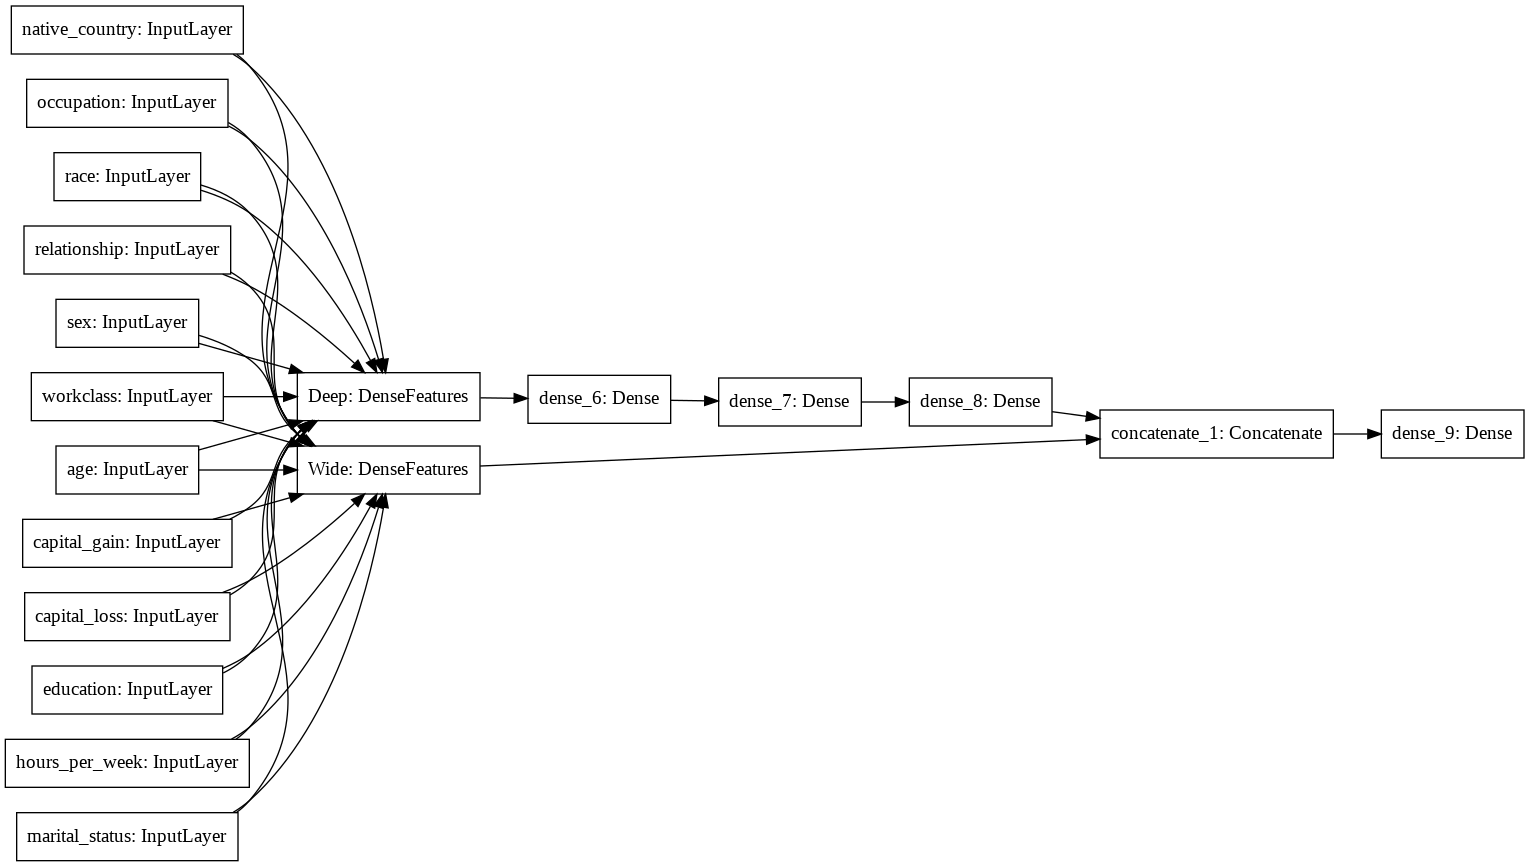

In [53]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

## Train

In [54]:
stop = EarlyStopping(patience=3)
history_wider = model.fit(dataset_train, validation_data=dataset_val,
                          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[stop])

Epoch 1/50
687/687 [==============================] - 8s 12ms/step - loss: 0.3700 - accuracy: 0.8356 - val_loss: 0.3180 - val_accuracy: 0.8600
Epoch 2/50
687/687 [==============================] - 7s 11ms/step - loss: 0.3174 - accuracy: 0.8522 - val_loss: 0.3075 - val_accuracy: 0.8632
Epoch 3/50
687/687 [==============================] - 7s 10ms/step - loss: 0.3100 - accuracy: 0.8546 - val_loss: 0.3079 - val_accuracy: 0.8620
Epoch 4/50
687/687 [==============================] - 7s 10ms/step - loss: 0.3082 - accuracy: 0.8567 - val_loss: 0.3045 - val_accuracy: 0.8628
Epoch 5/50
687/687 [==============================] - 7s 11ms/step - loss: 0.3037 - accuracy: 0.8597 - val_loss: 0.3151 - val_accuracy: 0.8554
Epoch 6/50
687/687 [==============================] - 7s 11ms/step - loss: 0.3005 - accuracy: 0.8605 - val_loss: 0.3055 - val_accuracy: 0.8649
Epoch 7/50
687/687 [==============================] - 7s 11ms/step - loss: 0.2984 - accuracy: 0.8605 - val_loss: 0.3062 - val_accuracy: 0.8583

## Test

In [55]:
results_wider = model.evaluate(dataset_test)
print("test loss, test acc:", results_wd)

255/255 [==============================] - 2s 7ms/step - loss: 0.3152 - accuracy: 0.8525
test loss, test acc: [0.3177884519100189, 0.854563295841217]


In [56]:
pred = model.predict(dataset_test)
pred_class = np.where(pred.squeeze() > 0.5, 1, 0)
accuracy = accuracy_score(pred_class, df_test.y)
print(f'Test Accuracy {accuracy * 100.:.2f}%')

Test Accuracy 85.25%


In [57]:
print(classification_report(pred_class, df_test.y))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      6496
           1       0.61      0.74      0.67      1645

    accuracy                           0.85      8141
   macro avg       0.77      0.81      0.79      8141
weighted avg       0.87      0.85      0.86      8141



# Comparison

In [58]:
results_df = pd.DataFrame(columns=['Loss', 'Accuracy'])
results_df.loc['Deep'] = results
results_df.loc['Wide & Deep'] = results_wd
results_df.loc['Wider'] = results_wider
results_df

,Loss,Accuracy
Deep,0.790497,0.827417
Wide & Deep,0.317788,0.854563
Wider,0.315185,0.852475
